c:\Users\rfeng6\.conda\envs\TFNN\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


(3089.8894819252682+0j)


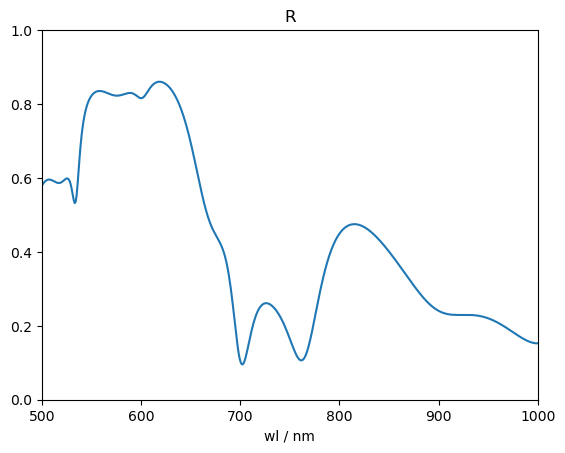

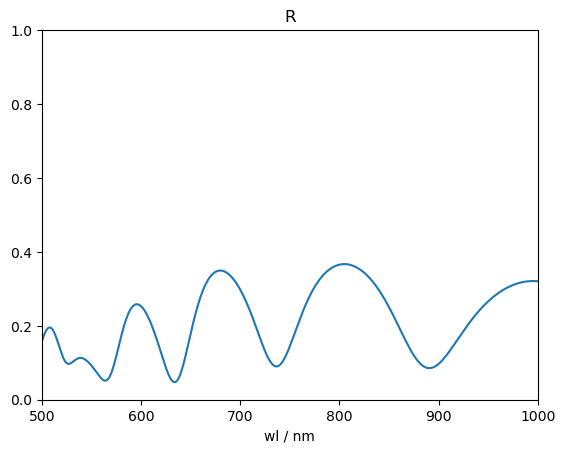

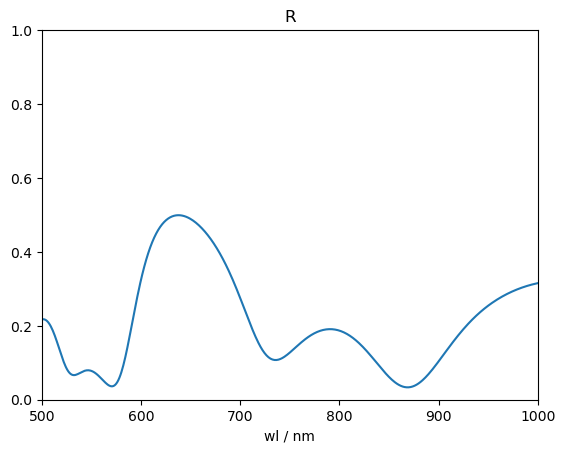

In [1]:
import sys
sys.path.append('./../../designer/script/')
import os
from gets.get_spectrum import get_spectrum_simple
from design import DesignSimple
from film import FilmSimple
from spectrum import SpectrumSimple
from utils.plot_spectrum import plot_spectrum
from utils.load_designs import load_designs_single_spec, init_film_single_spec
from utils.sort import sort_by_ith_list
import numpy as np
import copy
from utils.loss import calculate_RMS
from utils.structure import diff_simple_film
import matplotlib.pyplot as plt

# Initialize: config for TML
WLS = np.linspace(500, 1000, 500)
INC_ANG = 60.
wl = 750. # wl used for calculating OT

def plot_film(f: FilmSimple):
    f.add_spec_param(INC_ANG, WLS)
    spec_target = f.get_spec()
    spec_target.calculate() # compile cuda kernel func
    plot_spectrum(spec_target)

np.random.seed(1)
f_target_30layers = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(30) * 100) # target film
plot_film(f_target_30layers)

np.random.seed(1)
f_target_4layers = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(4) * 750) # target film
plot_film(f_target_4layers)

np.random.seed(1)
f_target_8layers = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(8) * 3000 / 8) # target film
init_film_single_spec(f_target_8layers, INC_ANG, WLS)

np.random.seed(3)
f_target_3layers_seed3 = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(3) * 3000 / 3) # target film
init_film_single_spec(f_target_3layers_seed3, INC_ANG, WLS)
print(f_target_3layers_seed3.get_optical_thickness(750))

np.random.seed(2)
f_target_4layers_seed2 = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(4) * 3000 / 4) # target film
plot_film(f_target_4layers_seed2)


np.random.seed(3)
f_target_5layers_seed3 = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(5) * 3000 / 5) # target film
init_film_single_spec(f_target_5layers_seed3, INC_ANG, WLS)



In [2]:
# Load trained films data and construct Design objects
runs_dict = {
            "SiO2_30layers": {},
            "TiO2_30layers": {},
            "SiO2_4layers": {},
            "TiO2_4layers": {}, 
            "SiO2_8layers": {},
            "TiO2_8layers": {},
            "SiO2_3layers_seed3": {},
            "SiO2_4layers_seed2": {},
            "SiO2_5layers_seed3": {},
            }
runs_dict['SiO2_30layers']['file_dir'] = './../raw_design_result/50iters_0to2OT_200run_SiO2_target30layers/'
runs_dict['TiO2_30layers']['file_dir'] = './../raw_design_result/50iters_0to2OT_200run_TiO2_target30layers/'
runs_dict['SiO2_4layers']['file_dir'] = './../raw_design_result/50iters_0to2OT_200run_SiO2_target4layers/'
runs_dict['TiO2_4layers']['file_dir'] = './../raw_design_result/50iters_0to2OT_200run_TiO2_target4layers/'
runs_dict['SiO2_8layers']['file_dir'] = './../raw_design_result/50iters_0to2OT_200run_SiO2_target8layers/'
runs_dict['TiO2_8layers']['file_dir'] = './../raw_design_result/50iters_0to2OT_200run_TiO2_target8layers/'

runs_dict['SiO2_3layers_seed3']['file_dir'] = './../raw_design_result/50iters_0to2OT_200run_SiO2_target3layers_seed3/'
runs_dict['SiO2_4layers_seed2']['file_dir'] = './../raw_design_result/50iters_0to2OT_200run_SiO2_target4layers_seed2/'
runs_dict['SiO2_5layers_seed3']['file_dir'] = './../raw_design_result/50iters_0to2OT_200run_SiO2_target5layers_seed3/'



runs_dict['SiO2_30layers']['save_fig_dir'] = './figs/50iters_0to2OT_200run_SiO2_target30layers/'
runs_dict['TiO2_30layers']['save_fig_dir'] = './figs/50iters_0to2OT_200run_TiO2_target30layers/'
runs_dict['SiO2_4layers']['save_fig_dir'] = './figs/50iters_0to2OT_200run_SiO2_target4layers/'
runs_dict['TiO2_4layers']['save_fig_dir'] = './figs/50iters_0to2OT_200run_TiO2_target4layers/'
runs_dict['SiO2_8layers']['save_fig_dir'] = './figs/50iters_0to2OT_200run_SiO2_target8layers/'
runs_dict['TiO2_8layers']['save_fig_dir'] = './figs/50iters_0to2OT_200run_TiO2_target8layers/'

runs_dict['SiO2_3layers_seed3']['save_fig_dir'] = './figs/50iters_0to2OT_200run_SiO2_target3layers_seed3/'
runs_dict['SiO2_4layers_seed2']['save_fig_dir'] = './figs/50iters_0to2OT_200run_SiO2_target4layers_seed2/'
runs_dict['SiO2_5layers_seed3']['save_fig_dir'] = './figs/50iters_0to2OT_200run_SiO2_target5layers_seed3/'



runs_dict['SiO2_30layers']['designs'] = load_designs_single_spec(runs_dict['SiO2_30layers']['file_dir'], f_target_30layers, n_A='SiO2', n_B='TiO2', n_sub='SiO2')
runs_dict['TiO2_30layers']['designs'] = load_designs_single_spec(runs_dict['TiO2_30layers']['file_dir'], f_target_30layers, n_A='TiO2', n_B='SiO2', n_sub='SiO2')
runs_dict['SiO2_4layers']['designs'] = load_designs_single_spec(runs_dict['SiO2_4layers']['file_dir'], f_target_4layers, n_A='SiO2', n_B='TiO2', n_sub='SiO2')
runs_dict['TiO2_4layers']['designs'] = load_designs_single_spec(runs_dict['TiO2_4layers']['file_dir'], f_target_4layers, n_A='TiO2', n_B='SiO2', n_sub='SiO2')
runs_dict['SiO2_8layers']['designs'] = load_designs_single_spec(runs_dict['SiO2_8layers']['file_dir'], f_target_8layers, n_A='SiO2', n_B='TiO2', n_sub='SiO2')
runs_dict['TiO2_8layers']['designs'] = load_designs_single_spec(runs_dict['TiO2_8layers']['file_dir'], f_target_8layers, n_A='TiO2', n_B='SiO2', n_sub='SiO2')

runs_dict['SiO2_3layers_seed3']['designs'] = load_designs_single_spec(runs_dict['SiO2_3layers_seed3']['file_dir'], f_target_3layers_seed3, n_A='SiO2', n_B='TiO2', n_sub='SiO2')
runs_dict['SiO2_4layers_seed2']['designs'] = load_designs_single_spec(runs_dict['SiO2_4layers_seed2']['file_dir'], f_target_4layers_seed2, n_A='SiO2', n_B='TiO2', n_sub='SiO2')
runs_dict['SiO2_5layers_seed3']['designs'] = load_designs_single_spec(runs_dict['SiO2_5layers_seed3']['file_dir'], f_target_5layers_seed3, n_A='SiO2', n_B='TiO2', n_sub='SiO2')

for key in runs_dict:
    if not os.path.isdir(runs_dict[key]['save_fig_dir']):
        os.makedirs(runs_dict[key]['save_fig_dir'])


Trained film should not have zero geometric thickness (run 0)
Trained film should not have zero geometric thickness (run 0)
Trained film should not have zero geometric thickness (run 0)


c:\Users\rfeng6\Desktop\working\Thin-Film-Design\working\OT-loss\./../../designer/script\utils\load_designs.py:37: UserWarning: loadtxt: input contained no data: "./../raw_design_result/50iters_0to2OT_200run_SiO2_target4layers/run_23/iter_0"
  np.loadtxt(file_dir + f'run_{run_idx}/iter_0', dtype=float)*1000.
c:\Users\rfeng6\Desktop\working\Thin-Film-Design\working\OT-loss\./../../designer/script\utils\load_designs.py:37: UserWarning: loadtxt: input contained no data: "./../raw_design_result/50iters_0to2OT_200run_SiO2_target4layers/run_31/iter_0"
  np.loadtxt(file_dir + f'run_{run_idx}/iter_0', dtype=float)*1000.
c:\Users\rfeng6\Desktop\working\Thin-Film-Design\working\OT-loss\./../../designer/script\utils\load_designs.py:37: UserWarning: loadtxt: input contained no data: "./../raw_design_result/50iters_0to2OT_200run_SiO2_target4layers/run_32/iter_0"
  np.loadtxt(file_dir + f'run_{run_idx}/iter_0', dtype=float)*1000.
c:\Users\rfeng6\Desktop\working\Thin-Film-Design\working\OT-loss\./../

Trained film should not have zero geometric thickness (run 0)
Trained film should not have zero geometric thickness (run 0)
Trained film should not have zero geometric thickness (run 0)
Trained film should not have zero geometric thickness (run 0)
Trained film should not have zero geometric thickness (run 0)
Trained film should not have zero geometric thickness (run 0)


In [3]:
def get_similarity_matrix(designs: list[DesignSimple]):
    n = len(designs)
    sim_arr = np.empty((n, n))
    # this takes ~ 30s to run for n=200
    for i in range(n):
        for j in range(n):
            sim_arr[i, j] = diff_simple_film(designs[i].film, designs[j].film, metric='abs', 
                                            norm=max(designs[i].get_init_gt(), designs[j].get_init_gt()) # use init thickness to avoid explosion
                                            )
    return sim_arr


runs_dict['SiO2_30layers']['arr'] = get_similarity_matrix(runs_dict['SiO2_30layers']['designs']) # time: about 1min
runs_dict['TiO2_30layers']['arr'] = get_similarity_matrix(runs_dict['TiO2_30layers']['designs']) # time: about 1min
runs_dict['SiO2_4layers']['arr'] = get_similarity_matrix(runs_dict['SiO2_4layers']['designs']) # time: about 1min
runs_dict['TiO2_4layers']['arr'] = get_similarity_matrix(runs_dict['TiO2_4layers']['designs']) # time: about 1min

runs_dict['SiO2_8layers']['arr'] = get_similarity_matrix(runs_dict['SiO2_8layers']['designs']) # time: about 1min
runs_dict['TiO2_8layers']['arr'] = get_similarity_matrix(runs_dict['TiO2_8layers']['designs']) # time: about 1min

runs_dict['SiO2_3layers_seed3']['arr'] = get_similarity_matrix(runs_dict['SiO2_3layers_seed3']['designs']) # time: about 1min
runs_dict['SiO2_4layers_seed2']['arr'] = get_similarity_matrix(runs_dict['SiO2_4layers_seed2']['designs']) # time: about 1min
runs_dict['SiO2_5layers_seed3']['arr'] = get_similarity_matrix(runs_dict['SiO2_5layers_seed3']['designs']) # time: about 1min


c:\Users\rfeng6\Desktop\working\Thin-Film-Design\working\OT-loss\./../../designer/script\utils\structure.py:50: RuntimeWarning: invalid value encountered in double_scalars
  l1_diff /= norm
c:\Users\rfeng6\Desktop\working\Thin-Film-Design\working\OT-loss\./../../designer/script\utils\structure.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  l1_diff /= norm


c:\Users\rfeng6\.conda\envs\TFNN\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\rfeng6\.conda\envs\TFNN\lib\site-packages\matplotlib\transforms.py:2860: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
c:\Users\rfeng6\.conda\envs\TFNN\lib\site-packages\matplotlib\transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


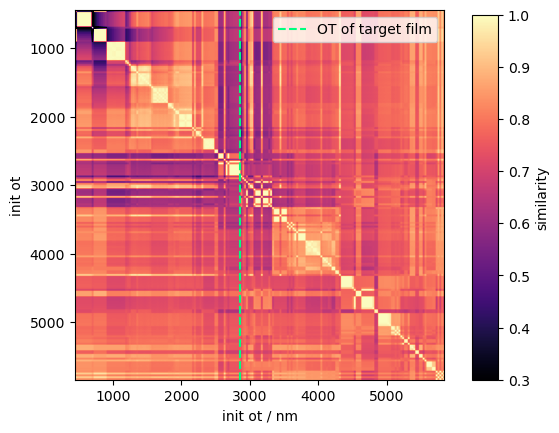

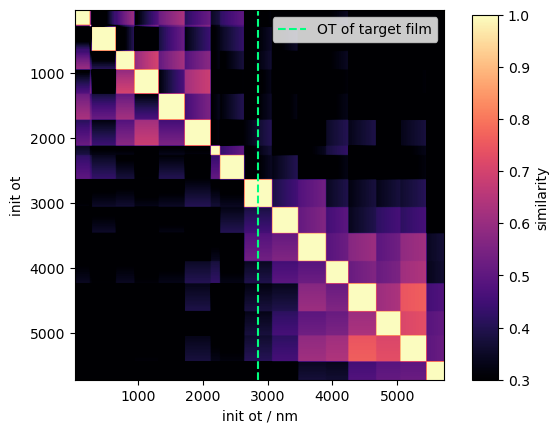

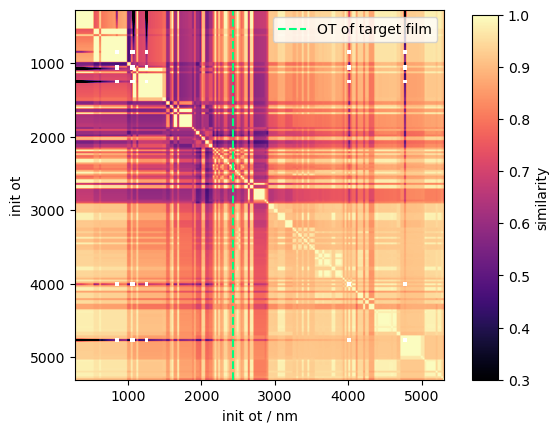

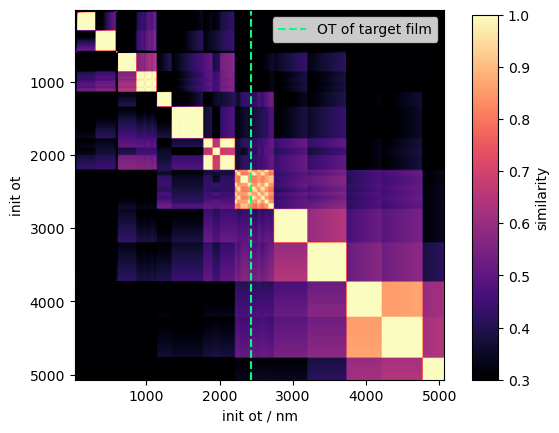

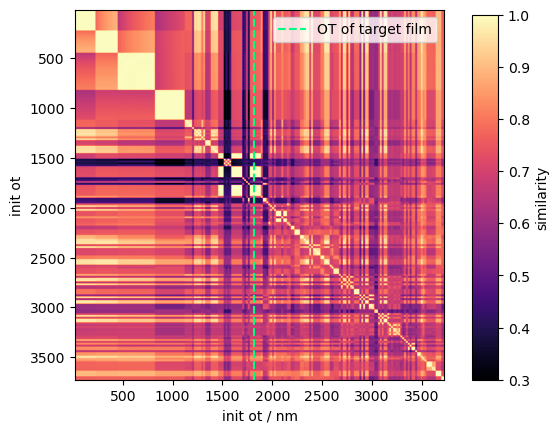

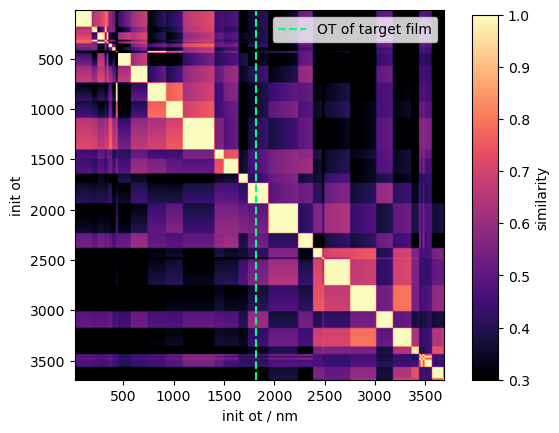

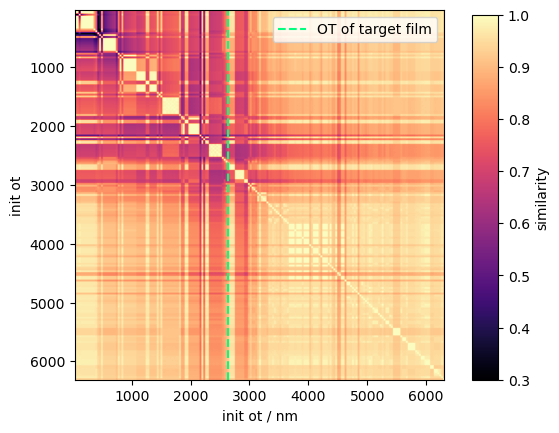

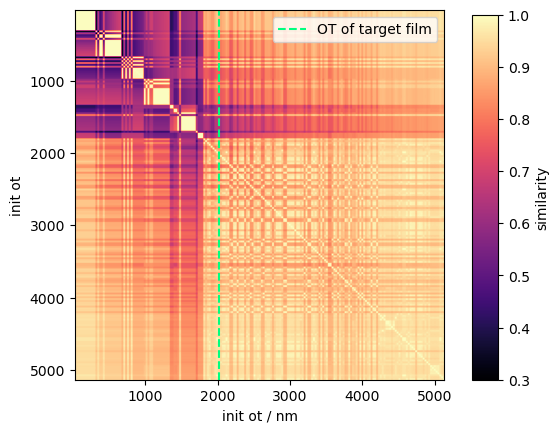

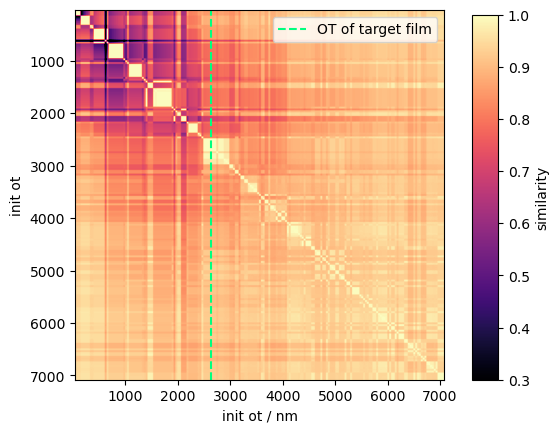

In [4]:
def plot_similarity_matrix(arr, designs: list[FilmSimple], vmax=0.6, vmin=0.3):
    wl = 750
    fig, ax = plt.subplots(1, 1)
    im = ax.imshow(1 - arr,
                    aspect='equal', 
                    extent=(designs[0].get_init_ot(wl),
                            designs[-1].get_init_ot(wl),
                            designs[-1].get_init_ot(wl),
                            designs[0].get_init_ot(wl)
                    ),
                    cmap='magma',
                    # vmax=vmax,
                    vmin = vmin
            )
    ax.set_xlabel('init ot / nm')
    ax.set_ylabel('init ot')

    # show target ot
    wl = 750
    target_ot = designs[0].get_target_ot(wl)
    ax.plot([target_ot, target_ot], ax.get_ylim(), label='OT of target film', c='springgreen', ls='--')
    ax.legend()

    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.82, 0.11, 0.04, 0.76])
    fig.colorbar(im, cax=cbar_ax, label='similarity')
    return fig, ax

for run_name in runs_dict:
    if 'seed' not in run_name:
        # continue
        pass
    fig, ax = plot_similarity_matrix(runs_dict[run_name]['arr'], runs_dict[run_name]['designs'], vmax=0.7)
    fig.savefig(runs_dict[run_name]['save_fig_dir'] + "similarity_matrix.png", dpi=300)

In [6]:

def plot_diff_wrt_target_final_ot(designs: list[DesignSimple]):
    # sort acording to final ot so that plot does not get messy
    final_ots = [design.get_current_ot() for design in designs]
    target_film = designs[0].target_film
    designs, _ = sort_by_ith_list(designs, final_ots, index=1)

    fig, ax = plt.subplots(1, 1)
    N = 5
    colors = plt.cm.get_cmap('twilight')(np.linspace(0, 1, N))
    for wl, color in zip(np.linspace(500, 1000, N), colors):
        # similarity w.r.t. t
        similarities: list[float] = []
        final_ots = []
        
        for design in designs:
            if design.get_current_ot() == 0 or design.get_current_gt() > 1e4:
                continue

            film = design.film
            similarity = 1 - diff_simple_film(film, target_film, wl=wl, norm=design.get_target_gt())
            similarities.append(similarity)
            final_ots.append(design.get_current_ot())

        ax.plot(final_ots, similarities, c=color, label=f'wl:{wl:.0f}', marker='.')
    ax.plot([design.get_target_ot(), design.get_target_ot()], [0, 1], 
            label='equal ot wrt target',
            ls=':',
            c='grey'
            )
    ax.set_ylim(0, 1)
    ax.set_xlim(0, design.get_target_ot() * 2)
    ax.legend()
    ax.set_xlabel('final ot / nm')
    
    return fig

def plot_diff_wrt_target_initial_ot(designs: list[DesignSimple]):
    # sort acording to initial ot so that plot does not get messy
    init_ots = [design.get_init_ot() for design in designs]
    target_film = designs[0].target_film
    designs, _ = sort_by_ith_list(designs, init_ots, index=1)

    fig, ax = plt.subplots(1, 1)
    N = 5
    colors = plt.cm.get_cmap('twilight')(np.linspace(0, 1, N))
    for wl, color in zip(np.linspace(500, 1000, N), colors):
        # similarity w.r.t. t
        similarities: list[float] = []
        init_ots = []
        
        for design in designs:
            if design.get_init_ot() == 0 or design.get_current_gt() > 1e4:
                continue

            film = design.film
            similarity = 1 - diff_simple_film(film, target_film, wl=wl, norm=design.get_target_gt())
            similarities.append(similarity)
            init_ots.append(design.get_init_ot())

        ax.plot(init_ots, similarities, c=color, label=f'wl:{wl:.0f}', marker='.')
    ax.plot([design.get_target_ot(), design.get_target_ot()], [0, 1], 
            label='equal ot wrt target',
            ls=':',
            c='grey'
            )
    ax.set_ylim(0, 1)
    ax.legend()
    ax.set_xlabel('init ot / nm')
    
    return fig

for run_name in runs_dict:
    # if 'seed' not in run_name:
    #     continue
    plot_diff_wrt_target_final_ot(
        runs_dict[run_name]['designs']
    ).savefig(
        runs_dict[run_name]['save_fig_dir'] + '/similarity_wrt_target-final_ot.png',
        dpi=300
    )

    plot_diff_wrt_target_initial_ot(
        runs_dict[run_name]['designs']
    ).savefig(
        runs_dict[run_name]['save_fig_dir'] + '/similarity_wrt_target-initial_ot.png',
        dpi=300
    )

